# Scheutjens-Fleer Self-Consistent Field

We employ a two-gradient SF-SCF method in cylindrical geometry. A full description is given in Supplementary Note 3 of the original work. Here we provide technical details sufficient for reproducibility.

We do not cover input-file generation in detail (this is well documented in the Namics/SFbox manual), but we include a minimal example below.

## Computing polymer density profiles in the absence of colloid particle

### Defining the system for SF-SCF
Each grafted chain is anchored by a monomer segment pinned to the pore wall. Pinned segments are constrained to the inner cylindrical surface (constant radius) and can translate along the $z$-axis (one fewer degree of freedom than a free segment). 
To prevent this lateral motion, the pore is partitioned into discrete slices (rings) along $z$; each slice defines its own grafting site, immobilizing pinned segments within that slice. For every slice, a fraction of chains is grafted so that the total polymer amount is evenly distributed along the pore and the grafting density is conserved.

Example input snippet from `SCF/empty_pore_input.in`:

```text
mol:pol0:composition:(P0)1(P)299
mol:pol0:freedom:restricted
mol:pol0:theta:980.1769079200155
mon:P0:freedom:pinned
mon:P0:pinned_range:26,121;26,121
...
mol:pol51:composition:(P0)1(P)299
mol:pol51:freedom:restricted
mol:pol51:theta:980.1769079200155
mon:P51:freedom:pinned
mon:P51:pinned_range:26,172;26,172
```

### Reading the output

The numerical SF-SCF algorithm minimizes the excess Helmholtz free energy subject to incompressibility, yielding the equilibrium polymer volume-fraction field originating from each grafting slice. In our system, the pore length is 52 lattice units with slices labeled $z=−26, \ldots ,+25$. Each slice corresponds to one set of grafted chains, allowing us to resolve how grafting position contributes to the overall distribution. Namics/SFbox output files provide local volume fractions $\phi_n(r, z)$ (and per-origin contributions) on the cylindrical lattice.

### Extracting polymer density profile

Internally, Namics/SFbox first computes the polymer density per segment. Summing over all segments of a given chain yields the contribution to polymer density from that chain (i.e. the molecular species corresponding to one grafting slice). Because in this grafting scheme we effectively have 52 ($L_0=52$) species (one for each slice along $z$), the full polymer brush density is obtained by summing across all species:

$$
\phi_n(r,z) = \sum_{s=1}^{N} \phi_{s,n}(r,z)
$$
$$
\phi(r,z) = \sum_{n=1}^{L} \phi_n(r,z)
$$

where  
- $s$ indexes chain segment ($s = 1, \dots, N$),
- $n$ indexes chain segment ($n = 1, \dots, L$), 
- $\phi_{s,n}(r,z)$ s the contribution of segment $s$ from chains grafted at slice $n$,  
- $\phi(r,z)$ is the total volume fraction.  


The code below loads these results

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, clear_output

from src.read_namics_output import (
    create_walls,
    build_scf_empty_pore_results,
)
from src.make_plot import plot_with_slider, plot_grid

# ------------------------------------------------------------
# Load SCF-SCF results for an unperturbed pore
# In this showcase, we use the "moderately poor" pore with χ_PS = 0.6
# ------------------------------------------------------------
SCF_empty_pore_result = build_scf_empty_pore_results(
    "SCF/output/empty_pore", chi_PS=0.6
)

R = SCF_empty_pore_result["R"]         # radial grid points
Z = SCF_empty_pore_result["Z"]         # axial grid points

# Polymer volume fraction contributions per grafting slice (list of 2D arrays)
phi_n = SCF_empty_pore_result["phi_n"]

# Total polymer density (sum over all slices)
phi_0 = SCF_empty_pore_result["phi"]

# If pore with colloid insertion is available, use its mask of impermeable cells
colloid_mask = SCF_empty_pore_result.get(
    "colloid_mask", np.zeros_like(phi_n[0])
)

# ------------------------------------------------------------
# Create mask for pore walls (impermeable region)
# ------------------------------------------------------------
pore_radius = 26
pore_length = 52
walls = create_walls(len(R), len(Z), pore_radius, pore_length)

### Plots
#### Contributions of the chain per slice of the grafting surface
An interactive **slider** is provided to scroll along the pore axis $z$, allowing visualization of how chains grafted at different axial positions contribute to the density distribution inside the pore.

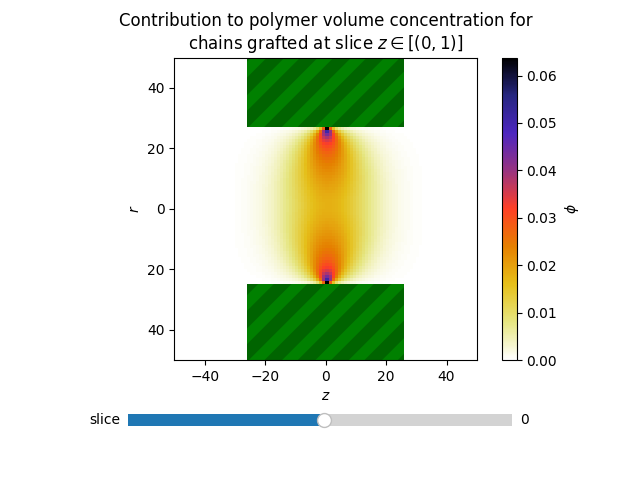

In [2]:
# ---------------------------------------------------------------
# Interactive plot: contributions from individual grafting slices
# ---------------------------------------------------------------
fig, ax = plot_with_slider(
    Z,
    R,
    phi_n,
    walls=walls,
    rlim=(-50, 50),
    zlim=(-50, 50),
)

### Unperturbed polymer density profile

We now plot the **total polymer volume fraction** $\phi(r,z)$, obtained by summing the contributions of all chains grafted along the pore.

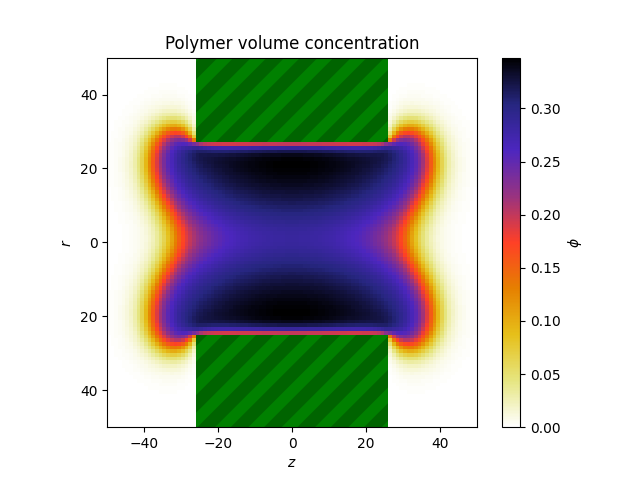

In [3]:
# ------------------------------------------------------------
# Plots unperturbed polymer density profile
# ------------------------------------------------------------
fig, ax = plot_grid(
    Z, 
    R, 
    phi_0, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50)
)


## Colloid traversing the pore: polymer density profiles and insertion free energy

Minor modifications to the input files allow us to model the insertion of a **cylindrical colloid particle** into the pore and, subsequently, its traversal along the central axis.  
The key changes are introduced in `SCF/colloid_traversing_pore.in`.

```text
mon:P:chi_C:0.0
mon:C:freedom:frozen
mon:C:frozen_range:1,18;3,23
...
start
mon:C:frozen_range:1,64;3,69
start
mon:C:frozen_range:1,65;3,70
start
mon:C:frozen_range:1,66;3,71
...
```

Here, the *frozen range* specifies lattice cells that are impermeable to the polymer, thereby representing the colloid.  
Sequential calculations with a rolling frozen range correspond to the particle moving stepwise along the pore axis.

In this example we model an **inert colloid**, with polymer-colloid interaction parameter $\chi_{\text{PC}} = 0$.  
We skip explicit summation over $\phi_n$ and instead use the **total polymer volume fraction** $\phi$.

### Reading the output

For each colloid position we collect:
- **Scalar quantities** such as the system free energy \(F_{\text{SF-SCF}}\). These are appended to `output/prefix.kal` during sequential calculations.
- **Density profiles** perturbed by the colloid. These are written to separate files `output/prefix_[idx].pro`, with `idx` incrementing from 1.
 
In `build_scf_results`, the **ground-state correction** for the insertion free energy is applied:

$$
\Delta F_{\text{SF-SCF}}(z_c) 
= F_{\text{SF-SCF}}(z_c) - F_{\text{SF-SCF}}(z_c^{\text{bulk}}),
$$

where $z_c^{\text{bulk}}$ is a reference position far from the pore.

The code below reads all output files and organizes them into an indexable `pandas` table. 


In [4]:
from src.read_namics_output import build_scf_results

# Parameters for this example calculation
input_parameters_for_SCF = {
    "colloid_diameter": 6,
    "colloid_positions": [-126] + list(range(-80, 1, 1)), # 82 positions in total; [-126] is chosen for ground-state correction
    "chi_PS": 0.6,
    "chi_PC": 0.0,
}

# Collect results into a pandas DataFrame
SCF_results = build_scf_results(
    "SCF/output/colloid_traversing_pore",
    **input_parameters_for_SCF,
    verbose=True,
)

clear_output()
display(SCF_results.head())

,colloid_position,free_energy,R,Z,colloid_mask,phi,chi_PS,chi_PC,colloid_diameter
0,-126,0.000000e+00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.807248975536214e-36, 4.810278853221177e-36...",0.6,0.0,6
1,-80,4.254362e-07,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3824091847953278e-36, 6.499113029499542e-3...",0.6,0.0,6
2,-79,-1.070552e-06,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3844317397246058e-36, 6.504955308354355e-3...",0.6,0.0,6
3,-78,-1.216409e-06,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.386297029449025e-36, 6.510346675233576e-36...",0.6,0.0,6
4,-77,-6.565788e-07,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3880129751339455e-36, 6.515309720142424e-3...",0.6,0.0,6


### Plots 
#### Colloid particle disturbs local polymer density

As whe chose $\chi_{\text{PC}} = 0$ which corresponds to inert colloid, one can see depleted region forming around the particle
The figure below provides intercative view, use slider to control colloid position.
Note the insertion free energy in the lower right box, it is always positive.
We keep other parameters fixed as in Figure 1 of the original work, $\chi_{\text{PS}} = 0.6$ and $d = 6$

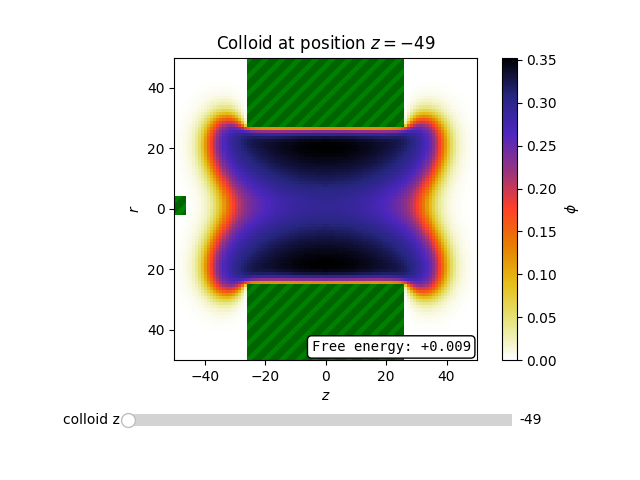

In [5]:
# --------------------------------------------------------------------------------
# Interactive plot: perturbed polymer concentration upon advancing colloid postion
# --------------------------------------------------------------------------------
from src.make_plot import plot_phi_with_colloid_slider
fig = plot_phi_with_colloid_slider(
    SCF_results, 
    fix_clim=True,
    walls=walls,     
    rlim = (-50,50),
    zlim = (-50,50)
    )

#### Insertion free energy vs. Colloid position

The central result of this exercise is the **insertion free energy profile**  
$$
\Delta F_{\text{SF-SCF}}(z_c) \;=\; \Delta F_{\text{SF-SCF}}(\chi_{\text{PS}}, \chi_{\text{PC}}, d, z_c),
$$
evaluated for the selected case $\chi_{\text{PC}} = 0$, $\chi_{\text{PS}} = 0.6$, and colloid diameter $d = 6$.

Below we present **Insertion free energy vs Colloid center position** plot.
 - $|z| > 26$ correspond to the space outside the pore lumen (exterior)
 - $|z| < 26$ colloid positions inside the pore lumen (interior)

Text(0.5, 0.98, 'Insertion free energy profile for cylindrical colloid particle\n calculated with SF-SCF')

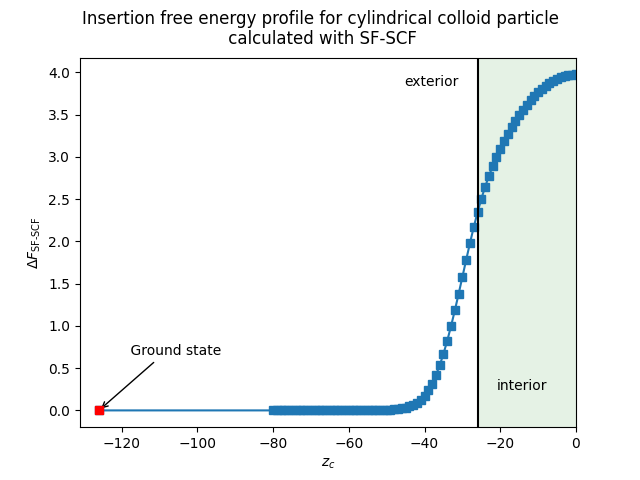

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from src.make_plot import plot_insertion_free_energy

fig, ax = plot_insertion_free_energy(SCF_results, pore_length=52, show_ground_state=True)
fig.suptitle("Insertion free energy profile for cylindrical colloid particle\n calculated with SF-SCF")


# Analytical estimation of insertion free energy for cylindrical colloids

The two-gradient SF-SCF method yields the position-dependent insertion free energy $\Delta F_{\text{SF-SCF}}(z_c)$ for a cylindrical colloid constrained coaxially along the $z$-axis, as described in the original work.

An analytical approach extends to arbitrarily positioned colloids. The osmotic term follows from the polymer volume fraction via a mean-field Flory expression, while the interfacial term includes entropic (confinement) and enthalpic (polymer-colloid, $\chi_{\text{ads}}$) contributions; at $\chi_{\text{ads}}=\chi_{\text{ads}}^{\text{crit}}$ the interfacial term vanishes. Local polymer perturbations near the surface are captured by two phenomenological parameters $b_0$ and $b_1$. See Eq. 17 of the original work.

For a coaxial cylinder, both methods apply, enabling a direct fit. We determine $b_0$ and $b_1$ by minimizing 
$$
\sum_{\text{parameters}}
\bigl|\Delta F_{\text{SF-SCF}} - \Delta F_{\text{cyl}}(b_0,b_1)\bigr|^2,
$$
where $\text{parameters}$ vary over $\chi_{\text{PS}}$, $\chi_{\text{PC}}$, and $z_c$.

The result of this section is a fit performed only for $\chi_{\text{PS}} = 0.6$ (fewer data points than in the original work) and $d = 4$ (same as in the original work).

## Data for fitting
### Precomputed dataset

The dataset required for fitting $b_0$ and $b_1$ can in principle be generated directly by running the two-gradient SF-SCF calculations.  
However, computing the full set of insertion free energy profiles for multiple values of $\chi_{\text{PC}}$ and $\chi_{\text{PS}}$ typically requires **several days** on a modern personal computer.  

For convenience and reproducibility, we therefore provide a **precomputed dataset** of SF-SCF results calculated with *namics/sfbox*.  
This dataset covers the case $\chi_{\text{PS}} = 0.6$ with colloid-polymer interaction parameters  
$\chi_{\text{PC}} = 0.0, -0.5, -1.0, -1.5$, for small colloids $d = 4, 6$ used in the fitting procedure.

In [7]:
import pandas as pd

# ----------------------------------------------------------------------
# Load precomputed SF-SCF results
# ----------------------------------------------------------------------
# To save time, we use a selection of precomputed results for small particles d= {4, 6}
# with chi_PS = 0.6 and chi_PC = {0.0, -0.5, -1.0, -1.5}.
#
# Direct calculation of this dataset would take several days on a modern
# personal computer, so we rely on cached results here.
# ----------------------------------------------------------------------

precomputed_SCF_results = pd.read_pickle(
    "/home/ml/Studium/sfb_empty_pore/precomputed_SCF_results.pkl"
)

display(precomputed_SCF_results[["chi_PS", "chi_PC", "colloid_position", "colloid_diameter", "free_energy"]])



,chi_PS,chi_PC,colloid_position,colloid_diameter,free_energy
804,0.6,-1.5,-126,4,0.000
3417,0.6,-0.5,-126,6,0.000
848,0.6,-1.5,-126,6,0.000
4472,0.6,0.0,-126,4,0.000
3343,0.6,-0.5,-126,4,0.000
...,...,...,...,...,...
2087,0.6,-1.0,21,4,-1.114
2065,0.6,-1.0,22,4,-1.111
2062,0.6,-1.0,23,4,-1.106
2046,0.6,-1.0,24,4,-1.099


#### Insertion free energy and polymer perturbations

Use the dropdown menu to select parameter values and adjust the colloid position with the slider.  
Observe both the insertion free energy and the strength of local polymer perturbations.  
For comparison, we recommend examining Figure S6 of the original work.

The dataset was computed with **high positional resolution** for small colloids, as these were used for fitting.  
Larger colloids were modeled more sparsely, serving primarily to establish the range of validity of the analytical approach.


In [8]:
# ----------------------------------------------------------------------
# Interactive exploration of precomputed SF-SCF results
# ----------------------------------------------------------------------
# Dropdown: select parameter set (χ_PS, χ_PC, colloid diameter)
# Slider:   move colloid along z-axis
# Output:   perturbed polymer density and insertion free energy
# ----------------------------------------------------------------------

from src.make_plot import interactive_plot_phi

interactive_plot_phi(
    precomputed_SCF_results,
    fix_clim=True,
    walls=walls,
    rlim=(-50, 50),
    zlim=(-50, 50),
)



TO PLOT SELECT PARAMETERS:


## Surface and volume projection matrices for cylindrical particles

Following Supplementary Note 4, the analytical calculation of $\Delta F_{\text{cyl}}$ requires **surface** and **volume** projection matrices.

While the colloid with diameter $d=4$ was used for fitting, it is instructive to also plot these matrices for larger particles, since they are needed when evaluating $\Delta F_{\text{cyl}}$ with the fitted model for different sizes.

Cylindrical particle volume projection matrix:
[[3.14159265 3.14159265 3.14159265 3.14159265]
 [9.42477796 9.42477796 9.42477796 9.42477796]]

Cylindrical particle surface projection matrix:
[[ 3.14159265  0.          0.          3.14159265]
 [21.99114858 12.56637061 12.56637061 21.99114858]]


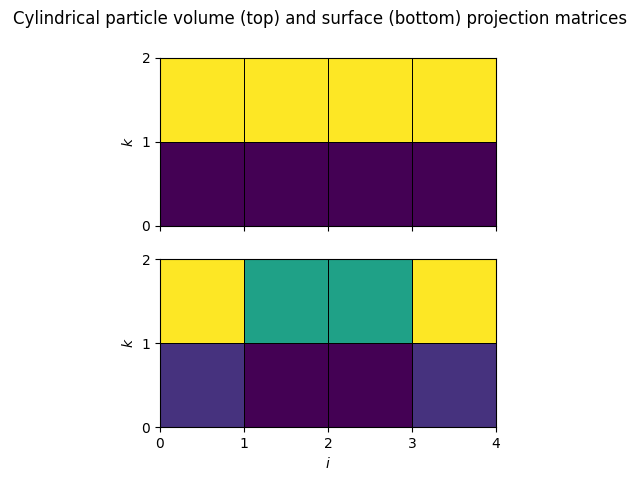

In [14]:
import numpy as np
from src.make_plot import plot_volume_and_surface_matrices_cylinder

# ----------------------------------------------------------------------
# Generate surface and volume projection matrices for a cylinder
# ----------------------------------------------------------------------
def cylinder_projection_matrices(radius: int, height: int = None):
    """
    Construct volume and surface projection matrices for a cylinder 
    of given radius and height coaxial to z-axis.

    Parameters
    ----------
    radius : int
        Cylinder radius (in lattice units).
    height : int, optional
        Cylinder height (defaults to diameter = 2*radius).

    Returns
    -------
    volume : ndarray
        Volume projection matrix.
    surface : ndarray
        Surface projection matrix.
    """
    if height is None:
        height = radius * 2

    r = np.arange(radius)
    volume_r = np.pi * (2 * r + 1)
    volume = np.tile(volume_r, (height, 1)).T
    surface = np.zeros_like(volume)

    # Top and bottom surfaces
    surface[:, 0] = surface[:, -1] = volume_r
    # Curved surface contribution
    surface[-1, :] += 2 * np.pi * radius

    return volume, surface


# Example: colloid with diameter d=4
COLLOID_DIAMETER = 4
volume, surface = cylinder_projection_matrices(COLLOID_DIAMETER // 2, COLLOID_DIAMETER)

plot_volume_and_surface_matrices_cylinder(volume, surface)


## Computing contributions to the insertion free energy

Following the original work (Supplementary Note 4), we build an analytical estimate of the insertion free energy $\Delta F_{\text{cyl}}$.

- The **interfacial term** is obtained from a local surface coefficient  
  $\gamma(\chi_{\text{PS}}, \chi_{\text{PC}}, \phi; X)$ - `gamma_model(chi_PS, chi_PC, phi, X)`,  
  where $X = (b_0,b_1)$ are phenomenological parameters.  
  Together with the surface projection matrix from `cylinder_projection_matrices`, this gives the interfacial free energy.

- The **osmotic term** is derived from the local osmotic pressure  
  $\Pi(\phi,\chi_{\text{PS}})$ - `Pi(phi, chi_PS)` and the corresponding volume matrix from `cylinder_projection_matrices`.

The analytical estimation of the resulting free energy is implemented in `insertion_free_energy_cylinder`.
Surface and volume projection matrices serves as convolution kernels in `scipy.signal.convolve` call, which essentially performs integration of corresponding distribution over the colloid surface or volume, to find insertion free energy contributions.


## Constructing the cost function

To determine the fitting parameters $b_0$ and $b_1$, we compare analytical predictions with SF-SCF results:

1. For each dataset characterized by $(\chi_{\text{PS}}, \chi_{\text{PC}}, d)$,  
   the unperturbed polymer profile $\phi\{\chi_{\text{PS}}\}(r,z)$ is taken from empty-pore simulations.

2. Using this profile, we compute $\Delta F_{\text{cyl}}(b_0,b_1)$ with the analytical model.

3. At every colloid position $z_c$, we calculate the **residual**
   $$
   r(z_c) \;=\; \Delta F_{\text{SF-SCF}}(z_c) - \Delta F_{\text{cyl}}(z_c; b_0,b_1).
   $$

4. All residuals are collected into a single vector across all datasets.

The **cost function** is then defined as the sum of squared residuals:
$$
\sum_{z_c,\,\chi_{\text{PC}},\,d}
\bigl[ \Delta F_{\text{SF-SCF}}(z_c) - \Delta F_{\text{cyl}}(z_c; b_0,b_1) \bigr]^2.
$$

We minimize this cost function using `scipy.optimize.least_squares` to obtain the fitted values of $b_0$ and $b_1$.


In [24]:
import numpy as np
from scipy.optimize import least_squares

# ----------------------------------------------------------------------
# Surface coefficient model
# ----------------------------------------------------------------------
def gamma_model(chi_PS, chi_PC, phi, X):
    """
    Local surface coefficient γ_model.

    Parameters
    ----------
    chi_PS : float
        Polymer-solvent interaction parameter.
    chi_PC : float
        Polymer-colloid interaction parameter.
    phi : ndarray
        Polymer volume fraction profile.
    X : tuple/list (b0, b1)
        Fitting parameters.

    Returns
    -------
    gamma : ndarray
        Local surface coefficient field.
    """
    b0, b1 = X
    chi_crit = 6 * np.log(5/6)
    phi_corr = (b0 + b1 * chi_PC) * phi
    chi_ads = chi_PC - chi_PS * (1 - phi_corr)
    gamma = (chi_ads - chi_crit) * phi_corr / 6
    return gamma


# ----------------------------------------------------------------------
# Osmotic pressure
# ----------------------------------------------------------------------
def Pi(phi, chi_PS):
    """Flory-Huggins osmotic pressure."""
    return -np.log(1 - phi) - phi - chi_PS * phi**2


# ----------------------------------------------------------------------
# Analytical insertion free energy for cylindrical colloid
# ----------------------------------------------------------------------
def insertion_free_energy_cylinder(radius, phi_0, chi_PS, chi_PC, gamma_model, X_args):
    """
    Compute insertion free energy ΔF_cyl from osmotic and interfacial terms.
    """
    from scipy.signal import convolve
    volume, surface = cylinder_projection_matrices(radius)

    # Pad to match projection kernel
    phi_0 = np.pad(phi_0[0:radius], ((0, 0), (radius, radius - 1)))

    Pi_arr = Pi(phi_0, chi_PS)
    gamma_arr = gamma_model(chi_PS, chi_PC, phi_0, X_args)

    osmotic = convolve(Pi_arr, volume, "valid")[0]
    interfacial = convolve(gamma_arr, surface, "valid")[0]
    return osmotic + interfacial


# ----------------------------------------------------------------------
# Cost function builder for fitting b0, b1
# ----------------------------------------------------------------------
def create_cost_function(SCF_results, SCF_results_empty, gamma_model):
    """
    Build cost function comparing SF-SCF results with analytical model.
    """
    def cost_function(X):
        cost = np.array([])
        for (chi_PS, chi_PC, diameter), group in SCF_results.groupby(
            by=["chi_PS", "chi_PC", "colloid_diameter"]
        ):
            # Retrieve unperturbed polymer profile for this chi_PS
            phi_0_data = SCF_results_empty.loc[
                SCF_results_empty.chi_PS == chi_PS, "phi"
            ]

            if len(phi_0_data)==0:
                raise ValueError(f"Unperturbed polymer density distribution is not provided for {chi_PS=}")
            elif len(phi_0_data)>1:
                raise ValueError(f"Too many unperturbed polymer density distribution provided for {chi_PS=}")
            else:
                phi_0 = phi_0_data.squeeze()

            FE = insertion_free_energy_cylinder(
                diameter // 2, phi_0, chi_PS, chi_PC, gamma_model, X
            )

            # Residuals between SCF data and analytical estimate
            residuals = group.apply(
                lambda row: row.free_energy - FE[int(row.colloid_position + len(FE)//2)],
                axis=1,
            )
            cost = np.concatenate([cost, residuals.to_numpy()])
        return cost

    return cost_function


# ----------------------------------------------------------------------
# Building the cost function and finding the best fit parameters b0, b1
# ----------------------------------------------------------------------
X0 = [1, 0]  # initial guess, no correction needed
cost_function = create_cost_function(
    precomputed_SCF_results,
    pd.DataFrame([SCF_empty_pore_result]),  # empty pore reference profiles
    gamma_model=gamma_model,
)
b0, b1 = map(float, least_squares(cost_function, X0).x)

print(f"Fit is successful! \n {b0=:.2f}, {b1=:.2f}")

Fit is successful! 
 b0=0.70, b1=-0.33


## Validation of the fit

Details of the fit validation are discussed in Supplementary Note 4 (Figures S5-S6).  
Here we revisit the insertion free energy profile for the selected case we chose in the beginning of this code showcase, i.e.
$\chi_{\text{PC}} = 0$, $\chi_{\text{PS}} = 0.6$, and colloid diameter $d = 6$.
Note that the fit was performed for smaller colloids with $d = 4$

As in Figure S5, we compare the analytical model with fitted parameters $(b_0,b_1)$  
against the non-fitted case $(b_0=1, b_1=0)$, which ignores polymer depletion/enrichment effects.


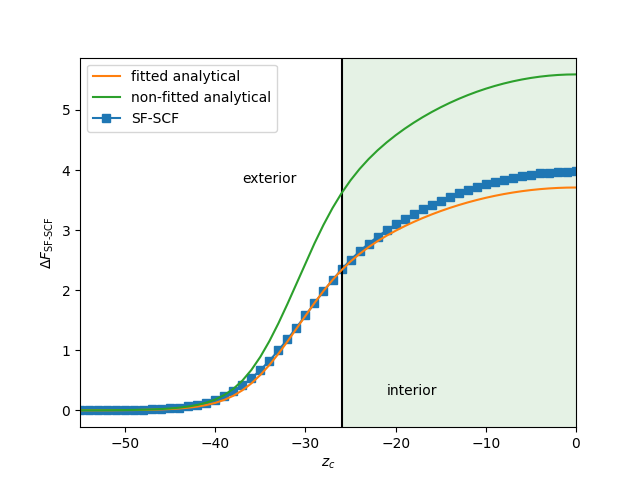

In [25]:
# --------------------------------------------------------------------------------
# Validation of the analytical fit against SF-SCF data
# --------------------------------------------------------------------------------

# Plot SF-SCF insertion free energy profile
fig, ax = plot_insertion_free_energy(SCF_results, pore_length=52, show_ground_state=False)
# fig, ax = plot_insertion_free_energy(
#     precomputed_SCF_results, 
#     pore_length=52, 
#     show_ground_state=False,
#     chi_PC = 0,
#     colloid_diameter = 6,
#     )

# Analytical insertion free energy using fitted parameters (b0, b1)
analytical_fe = insertion_free_energy_cylinder(
    radius=6 // 2,
    phi_0=phi_0,
    chi_PS=0.6,
    chi_PC=0,
    gamma_model=gamma_model,
    X_args=(b0, b1),
    # Alternative: X_args=(0.7, -0.3)  # values reported in the original work
)

# Analytical insertion free energy using default (non-fitted) parameters
analytical_fe_nofit = insertion_free_energy_cylinder(
    radius=6 // 2,
    phi_0=phi_0,
    chi_PS=0.6,
    chi_PC=0,
    gamma_model=gamma_model,
    X_args=(1, 0),
)

# Axial positions (centered around zero)
z = np.arange(len(analytical_fe)) - len(analytical_fe) // 2

# Overlay analytical results on the SF-SCF curve
ax.plot(z, analytical_fe, label="fitted analytical")
ax.plot(z, analytical_fe_nofit, label="non-fitted analytical")

# Dummy plot entry to preserve SF-SCF legend label
ax.plot([], [], color="tab:blue", marker="s", label="SF-SCF")

ax.set_xlim(-55, 0)

ax.legend()


# Generalization of the analytical approximation to spherical colloids

Following the steps in Supplementary Note 5 of the original work:

## Surface and volume projections for arbitrary place spherical colloids in cylindrical coordinates
For a given colloid diameter and radial offset $r_c$ (radial coordinate of the colloid center), the code generates **volume and surface matrices** as in Eqs. S49-S50 of the original work.  
These are then used to calculate insertion free energy contributions according to Eqs. S51-S52.

A detailed geometrical explanation is provided in Figure S8 and the accompanying text of Supplementary Note 4.


We also provide an interactive plot to explore how the volume and surface matrices change with radial shift (cf. Figure S7).  
As the radial offset increases, the projections increasingly resemble orthogonal projections; in the limit of large offsets, they become equivalent.  
By contrast, when the radial offset is smaller than the colloid radius, the resulting matrices are not square.

⚠️ **Note:** Changing the colloid diameter may take up to ~10 minutes while the cache is being filled. Once cached, the interactive updates remain responsive. Our implementation uses a numerical brute-force approach, integrating volumes and surfaces on a fine $(r,z)$ grid, rather than applying the algebraic simplifications described in the original work (see `src/sphere.py`).  
Since the resulting volume and surface matrices are cached and calculated once, additional optimizations were not pursued.




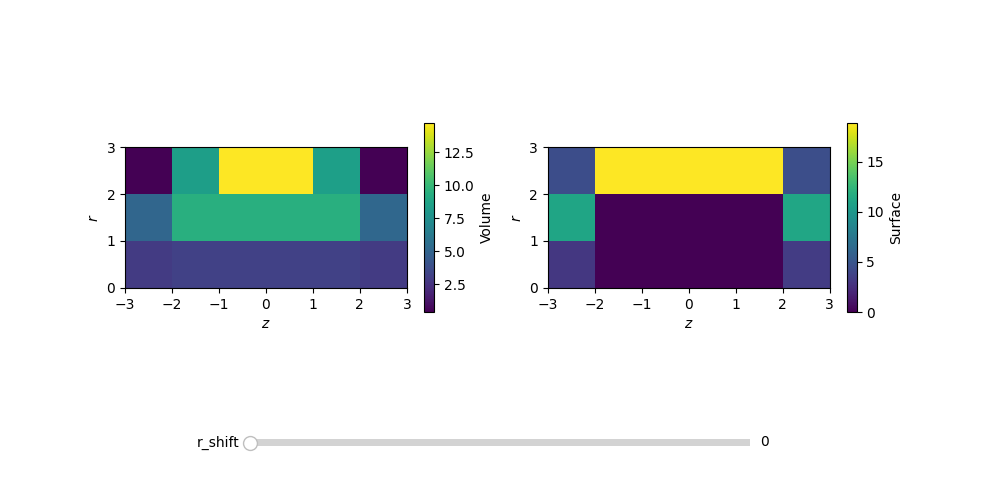

In [26]:

from src.sphere import generate_sphere_volume_surface_matrices
from src.make_plot import interactive_sphere_kernels

# Parameters
COLLOID_DIAMETER = 6
initial_r_shift = 0

#fill up cache to make figures
max_r_shift = 70 #no reason to make it larger
for r_ in range(max_r_shift):
    print(f"Filling up cache: {r_+1}/{max_r_shift}", end="\r", flush=True)
    generate_sphere_volume_surface_matrices(COLLOID_DIAMETER // 2, (0, r_))
clear_output()

interactive_sphere_kernels(COLLOID_DIAMETER)
pass

## Volume exclusion
The effect of volume exclusion was discussed throughout the main work, for the spherical colloid of diameter $d$ the effective pore size is $L = L_0 + d$ in length and $r_{\text{pore}} = r_{\text{pore}}^0 + d/2$ in radius.
A more detailed shaped is result of morphological dilation of the pore membrane with a solid sphere. On the cylindrical lattice the effect is shown in Figure S10 and explained in Supplementary Note 6 of the original work.

The code below produce mask of impermeable to the colloid positions as the result of the binary dilation `scipy.ndimage.binary_dilation`

Text(0.5, 1.0, 'Excluded volume')

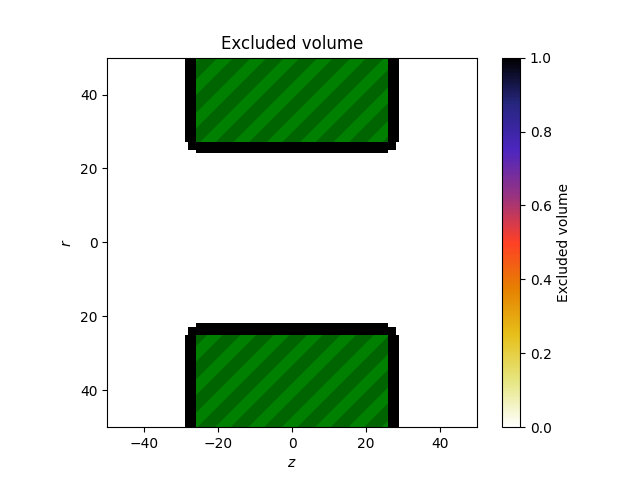

In [27]:
walls0 = create_walls(len(R), len(Z), pore_radius, pore_length)#no volume exclusion effect yet
COLLOID_DIAMETER = 6
walls = create_walls(len(R), len(Z), pore_radius, pore_length, COLLOID_DIAMETER)
# walls = create_walls(len(R), len(Z), pore_radius -  COLLOID_DIAMETER//2, pore_length + COLLOID_DIAMETER)

# ------------------------------------------------------------
# Plots impermeable to the particle space due to volume exclusion
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    walls, 
    walls = walls0,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"Excluded volume"
)
ax.set_title("Excluded volume")

## Computing insertion free energy profile

The insertion free energy for a spherical colloid is evaluated as the sum of two contributions:

1. **Osmotic term** — obtained by convolving the local osmotic pressure field  
   $\Pi(r,z;\chi_{\text{PS}})$ with the precomputed **volume projection matrix** $V(r_{\text{c}})$.
   This corresponds to the discretized form of Eq. (15):
   $$
   \Delta F_{\text{osm}}(r_{\text{c}}, z_{\text{c}}) =
   \mathbf{V}\{r_{\text{c}}\} \cdot \mathbf{\Pi}\{r_{\text{c}},z_{\text{c}}\}.
   $$

2. **Interfacial term** — obtained by convolving the local surface coefficient field  
   $\gamma(r,z;\chi_{\text{PS}},\chi_{\text{PC}})$ with the **surface projection matrix** $S(r_{\text{c}})$:
   $$
   \Delta F_{\text{sur}}(r_{\text{c}}, z_{\text{c}}) =
   \mathbf{S}\{r_{\text{c}}\} \cdot \mathbf{\gamma}\{r_{\text{c}},z_{\text{c}}\}.
   $$

Both terms are evaluated by discrete convolutions over the cylindrical lattice, with projection matrices used as kernels.  
The projection matrices $V$ and $S$ encode the geometry of a spherical particle of diameter $d$  
placed at an arbitrary radial offset $r_{\text{c}}$.

In [29]:
def convolve_particle_volume(array, particle_d):
    r"""
    Compute the osmotic contribution to the insertion free energy for a spherical colloid
    by convolving the polymer osmotic pressure field with the sphere's **volume projection matrix**.

    The volume projection matrix is used as a convolution kernel. For each radial
    position of the colloid center, the corresponding matrix is generated and applied to the
    polymer field `array` using a discrete convolution. The procedure effectively integrates
    the polymer osmotic pressure over the colloid volume while preserving the cylindrical lattice
    of the SF-SCF model.

    Parameters
    ----------
    array : ndarray of shape (nr, nz)
        2D array representing the polymer field (e.g. osmotic pressure $\Pi(r,z)$)
        defined on a cylindrical lattice with radial index `nr` and axial index `nz`.
    particle_d : int
        Diameter of the spherical colloid in lattice units.

    Returns
    -------
    ndarray of shape (nr, nz-1)
        2D array of the osmotic free energy contribution, aligned with the original grid.
        The output is averaged along the axial direction to correct for the half-step shift
        introduced by the even convolution kernel.

    Notes
    -----
    - Internally, the input array is padded along the axial dimension to accommodate
      the convolution at the boundaries.
    - Each radial row is convolved with the sphere's volume projection matrix generated
      at that radial offset.
    - Because the kernel is symmetric (even), the convolution result is shifted by half
      a step; this is corrected by averaging neighboring points.
    """
    from scipy.signal import convolve
    nr, nz = np.shape(array)
    particle_r = int(particle_d//2)
    array = np.pad(array, ((0, particle_r),(particle_r,particle_r)), 'edge')
    new_arr = []
    for r in range(nr):
        volume, surface, extent = generate_sphere_volume_surface_matrices(particle_r,r)
        zconv_result=convolve(array[int(extent[2]):int(extent[3])], volume, mode="valid")
        new_arr.append(zconv_result)
    new_arr = np.vstack(new_arr)
    # because convolution kernel is even 
    # the result is shifted by half a step along the axis
    # we either 'trim' the last index to have 
    # the the shape of the input array,
    # or shift it back by 'roll' averaging neighboring elements
    new_arr = (new_arr[:,1:]+new_arr[:,:-1])/2
    return new_arr

def convolve_particle_surface(array, particle_d):
    r"""
    Compute the interfacial contribution to the insertion free energy for a spherical colloid
    by convolving the polymer-surface interaction field with the sphere's **surface projection matrix**.

    The surface projection matrix is used as a convolution kernel. For each radial
    position of the colloid center, the corresponding matrix is generated and applied to the
    polymer field `array` using a discrete convolution. The procedure effectively integrates
    the local surface free-energy density over the colloid surface while preserving the
    cylindrical lattice of the SF-SCF model.

    Parameters
    ----------
    array : ndarray of shape (nr, nz)
        2D array representing the polymer-surface field (e.g. local coefficient $\gamma(r,z)$)
        defined on a cylindrical lattice with radial index `nr` and axial index `nz`.
    particle_d : int
        Diameter of the spherical colloid in lattice units.

    Returns
    -------
    ndarray of shape (nr, nz-1)
        2D array of the surface free energy contribution, aligned with the original grid.
        The output is averaged along the axial direction to correct for the half-step shift
        introduced by the even convolution kernel.

    Notes
    -----
    - Internally, the input array is padded along the axial dimension to accommodate
      the convolution at the boundaries.
    - Each radial row is convolved with the sphere's surface projection matrix generated
      at that radial offset.
    - Because the kernel is symmetric (even), the convolution result is shifted by half
      a step; this is corrected by averaging neighboring points.
    """
    from scipy.signal import convolve
    nr, nz = np.shape(array)
    particle_r = int(particle_d//2)
    array = np.pad(array, ((0, particle_r),(particle_r,particle_r)), 'edge')
    new_arr = []
    for r in range(nr):
        volume, surface, extent = generate_sphere_volume_surface_matrices(particle_r,r)
        zconv_result=convolve(array[int(extent[2]):int(extent[3])], surface, mode = 'valid')#[:,1:]
        new_arr.append(zconv_result)
    
    new_arr = np.vstack(new_arr)
    # because convolution kernel is even 
    # the result is shifted by half a step along the axis
    # we either 'trim' the last index to have 
    # the the shape of the input array,
    # or shift it back by 'roll' averaging neighboring elements
    new_arr = (new_arr[:,1:]+new_arr[:,:-1])/2
    return new_arr

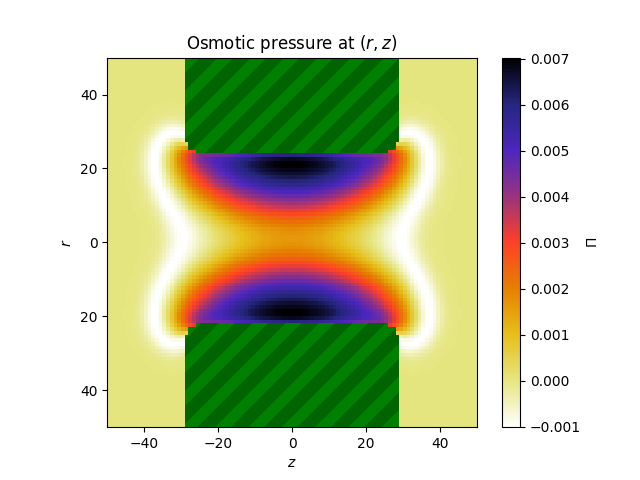

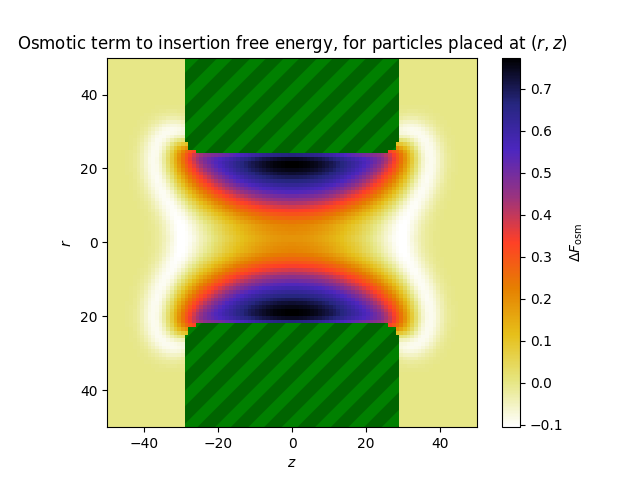

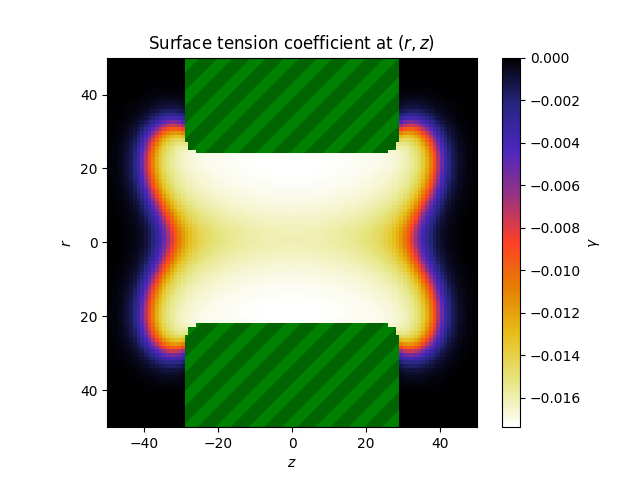

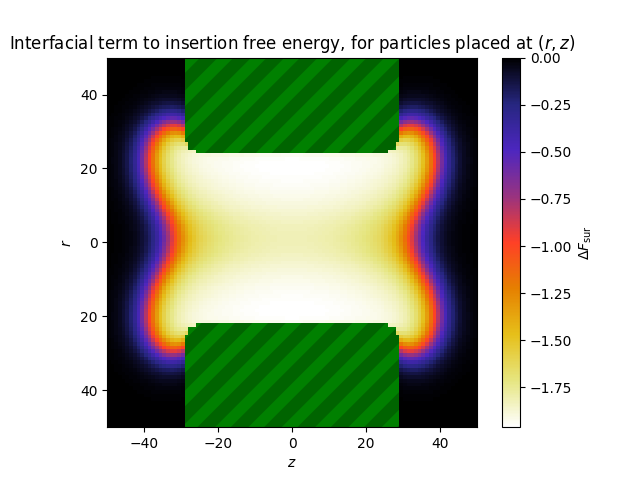

In [30]:
# Calculate local surface tension coefficient using fitted b0 b1

#Let us continue with attractive particle
chi_PC = -1.0
COLLOID_DIAMETER = 6

# Local surface tension coefficient
gamma = gamma_model(
    chi_PS = SCF_empty_pore_result["chi_PS"], 
    phi = SCF_empty_pore_result["phi"],
    chi_PC = chi_PC,
    X=(b0, b1)
    )

# Local osmotic pressure
pressure = Pi(chi_PS = SCF_empty_pore_result["chi_PS"],
              phi = SCF_empty_pore_result["phi"])

# Now let us find osmotic and interfacial term to insertion free energy in every position via convolution
fe_osm = convolve_particle_volume(pressure, COLLOID_DIAMETER)
fe_sur = convolve_particle_surface(gamma, COLLOID_DIAMETER)


# ------------------------------------------------------------
# Plots local osmotic pressure
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    pressure, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$\Pi$"
)
ax.set_title("Osmotic pressure at $(r,z)$")

# Now let us find interfacial term to insertion free energy in every position via convolution
fe_sur = convolve_particle_surface(gamma, COLLOID_DIAMETER)

# ------------------------------------------------------------
# Plots osmotic term to insertion free energy
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    fe_osm, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$\Delta F_{\text{osm}}$"
)
ax.set_title("Osmotic term to insertion free energy, for particles placed at $(r,z)$")


# Local osmotic pressure
pressure = Pi(chi_PS = SCF_empty_pore_result["chi_PS"],
              phi = SCF_empty_pore_result["phi"])

# ------------------------------------------------------------
# Plots local surface tension coefficient
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    gamma, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$\gamma$"
)
ax.set_title("Surface tension coefficient at $(r,z)$")


# ------------------------------------------------------------
# Plots interfacial term to insertion free energy
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    fe_sur, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$\Delta F_{\text{sur}}$"
)
ax.set_title("Interfacial term to insertion free energy, for particles placed at $(r,z)$")
pass

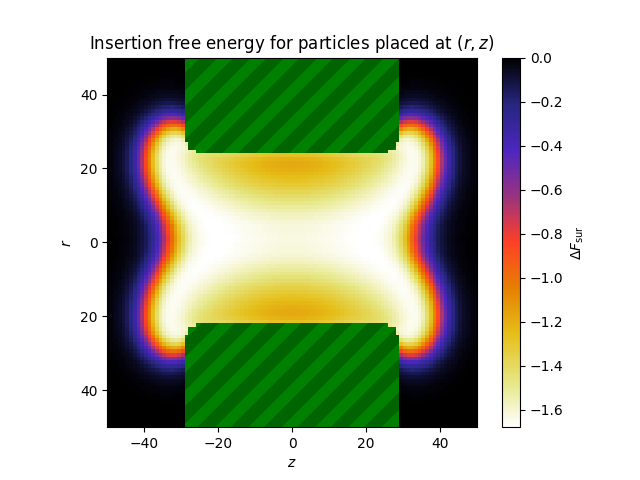

In [31]:
#finally total free energy
fe = fe_sur+fe_osm
# ------------------------------------------------------------
# Plots total insertion free energy
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    fe, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$\Delta F_{\text{sur}}$"
)
ax.set_title("Insertion free energy for particles placed at $(r,z)$")
pass

/tmp/ipykernel_526492/3503739870.py:5: RuntimeWarning: divide by zero encountered in divide
  eps = np.where(phi==0, 0.0, 1/phi)


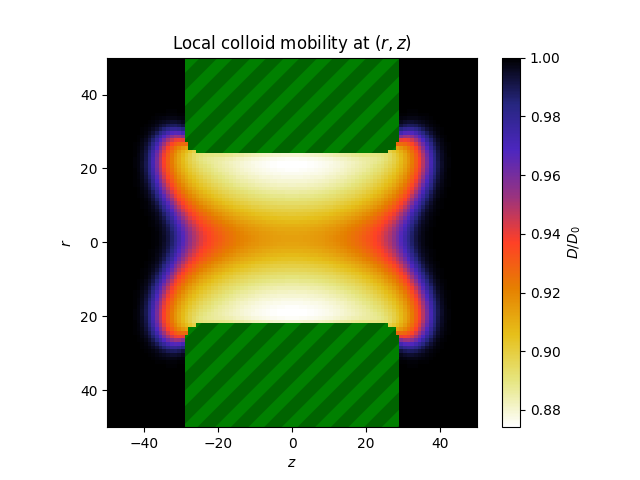

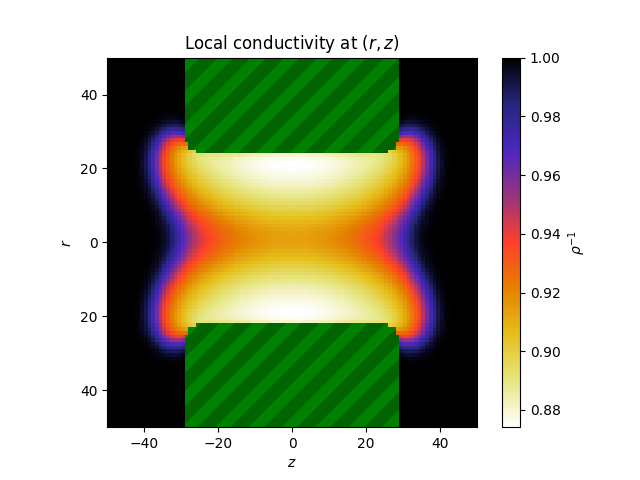

In [32]:
def calculate_mobility(phi, d, k = 1, prefactor = 5.5):
    if prefactor==0:
        m = np.ones_like(phi)
        return m
    eps = np.where(phi==0, 0.0, 1/phi)
    m = (prefactor*eps/d)**2
    m = m /(1.0 + m**k)**(1 / k)
    m = np.where(phi>0, m, 1.0)
    return m

def calculate_conductivity(mobility, insertion_free_energy, colloid_diameter, D_0 = "Einstein"):
    if D_0 == "Einstein":
        D_0 = 1/(3*np.pi*colloid_diameter)
    elif D_0 is None:
        D_0 = 1
    elif isinstance(D_0, float|int):
        pass
    else:
        raise ValueError("Incorrect D_0")
    conductivity  = mobility*np.exp(-insertion_free_energy)*D_0
    return conductivity

mobility = calculate_mobility(phi_0, COLLOID_DIAMETER)

# ------------------------------------------------------------
# Plots local mobility
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    mobility, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$D/D_0$"
)
ax.set_title("Local colloid mobility at $(r,z)$")

conductivity = calculate_conductivity(mobility, fe, COLLOID_DIAMETER, D_0 = 1)

# ------------------------------------------------------------
# Plots local mobility
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    mobility, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$\rho^{-1}$"
)
ax.set_title("Local conductivity at $(r,z)$")
pass

Flux: 85.42667681745893 Resistance: 0.011705945229928771
---Permeability-----------------------------------
Numerical result: 41.310723317398995
Analytical result for an empty pore: 17.655712891850477


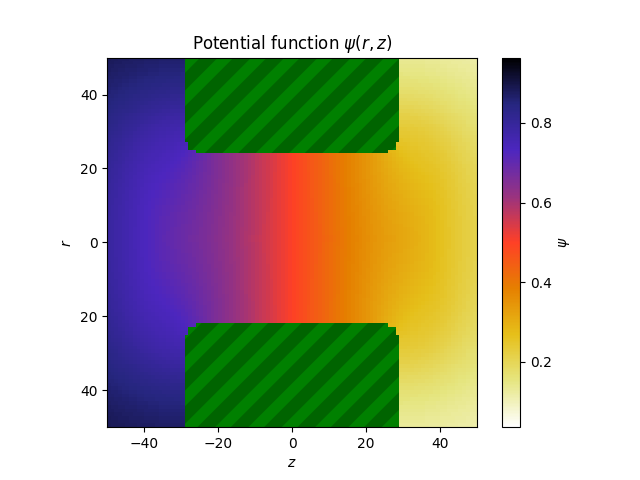

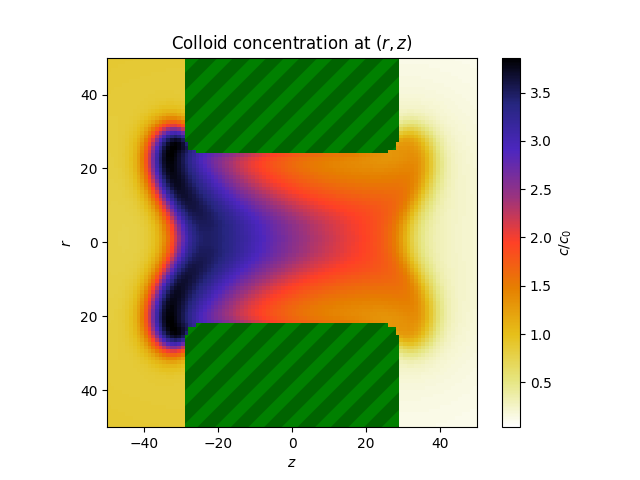

In [ ]:
from src.smoluchowski import solve_resistance

smoluchowski_results = solve_resistance(
    conductivity, walls, 
    pore_radius, pore_length, 
    D_0 = 1, 
    z_boundary=400, 
    colloid_diameter=COLLOID_DIAMETER
    )


# ------------------------------------------------------------
# Plots potential function ψ(r,z)
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    smoluchowski_results["psi"], 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$\psi$"
)
ax.set_title(r"Potential function $\psi(r,z)$")


colloid_concentration = smoluchowski_results["psi"]*np.exp(-fe)
# ------------------------------------------------------------
# Plots potential function ψ(r,z)
# ------------------------------------------------------------
fig, ax = plot_grid(
    SCF_empty_pore_result["Z"], 
    SCF_empty_pore_result["R"], 
    colloid_concentration, 
    walls = walls,
    rlim = (-50,50),
    zlim = (-50,50),
    cbar_label=r"$c/c_0$"
)
ax.set_title(r"Colloid concentration at $(r,z)$")

def empty_pore_permeability(D, r, s):
    return 2*D*r/(1 + 2*s/(r*np.pi))
perm_0_analytic = empty_pore_permeability(1, pore_radius-COLLOID_DIAMETER//2, pore_length+COLLOID_DIAMETER)

print("---Permeability-----------------------------------")
print(f"Numerical result: {1/smoluchowski_results['R']}")
print(f"Analytical result for an empty pore: {perm_0_analytic}")